# CISC-839 Data Analytics Project

## A Session Based - Recommendation System

This Sysyem is a session-based recommendation system, powered by the Ternec dataset. Leveraging the [Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems](https://proceedings.neurips.cc/paper_files/paper/2022/file/4ad4fc1528374422dd7a69dea9e72948-Paper-Datasets_and_Benchmarks.pdf) Paper, we aim to deliver personalized recommendations that adapt to users' session-specific preferences in real-time. Join us as we revolutionize the way users discover content by harnessing the power of session-based modeling and the rich insights provided by the Ternec dataset.

---

## Team Members
- Adham Mokhtar
- Manar El-Ghobashy
- Yara Mohammed
- Yara El-Zahy

---

## Some Explainations

A recommendation system is like having a smart computer friend that suggests things you might like based on the things you already enjoy. It helps you discover new things that you'll love!


There are three main types of recommendation systems:
1. Content-Based: It recommends things based on the features of what you already like. For example, if you enjoy action movies, it will suggest more action movies.
2. Collaborative Filtering: It recommends things based on what other people with similar tastes enjoy. If someone similar to you likes a certain video game, it will suggest that game to you.
3. Hybrid: This combines different methods to give you even better recommendations. It uses both the features of what you like and what other people like to suggest things you'll enjoy.

"Session-based" and "cold start" are specific challenges or scenarios that can occur in recommendation systems:
- Session-based Recommendations: This means giving recommendations based on what you're doing right now. For example, if you're browsing a website, it suggests things related to what you're looking at.
- Cold Start Problem: This happens when the system doesn't know much about a new user or item. It's like when you join a new website or they add new things. The system has to find other ways to give you recommendations since it doesn't have much information yet.

In this notebook (project) we will use collaborative filtering to try solving the session-based challenge.

For session-based recommendations, a type of recommendation system called "Sequential Recommendation" is more suitable.

- Sequential Recommendation systems are specifically designed to make recommendations based on a user's current session or sequence of actions within a single browsing session. These systems analyze the order and context of the user's interactions to understand their immediate preferences and provide relevant suggestions.
- In a session-based recommendation system, the focus is on capturing the user's current interests and recommending items that align with those interests. This type of system takes into account the sequence of actions, such as clicks, views, or purchases, during a session to make accurate and timely recommendations.

---

## Recommended Pipline
- Data Acquisition
- Data Preprocessing
- Feature Engineering
- Session Representation
- Train-Test-Validation Split
- Model Selection
    - Model Training
    - Model Evaluation
    - Hyperparameter Tuning
    - Performance Analysis

---

## Import Libraries

In [68]:
# general
import time
import math
import numpy as np
import pandas as pd

import tensorflow as tf

# graphs
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

---

## Useful/Common Methods

In [69]:
def display_value_counts_bar(df, ncols):
    nrows = int(np.ceil(len(df.columns)/ncols))
    if nrows > 1:
        _, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 20))
    else:
        _, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 5))

    row_index = 0
    for index, column in enumerate(df.columns):
        if (index != 0) and (index % ncols == 0):
            row_index += 1

        if nrows > 1:
            ax = axes[row_index, index % ncols]
        else: 
            ax = axes[index]

        ax.set_title(column)
        ax.tick_params(axis = 'x', labelrotation = 180)

        top_counts = df[column].value_counts().sort_values(ascending = False).head(10)
        top_counts.plot.bar(ax=ax)

    plt.tight_layout()
    plt.show()

In [70]:
def correlation(data):
    plt.figure(figsize = (20, 20))
    sns.set(font_scale=0.7)
    sns.heatmap(np.round(data._get_numeric_data().corr(), 2), annot = True, cmap="Greens")
    plt.show()

In [71]:
def display_value_counts_between(data, column1, column2):
    data.groupby(column1)[column2].value_counts().plot.bar()

In [72]:
def display_sum_between(data, column1, column2):
    data.groupby(column1)[column2].apply('sum').sort_values(ascending=False).head(20).plot.bar()


---

## Data Acquisition

The four datasets used in this paper are raw datasets:
- `QK-video.csv`
- `QK-article.csv`
- `QB-video.csv`
- `QB-article.csv`

All task-specific datasets are extracted from these datasets. 

Subdataset:

1. `ctr_data_1M.csv` is used in CTR task (Section 3.1) and Multi-Task Learning  (Section 3.3).

2. `cold_data.csv` (Table 7, Section 3.6), `cold_data_1.csv`, `cold_data_0.3.csv`, `cold_data_0.7.csv` are used for the Cold-Start task (see Appendix Table 5).

3. `task_0.csv`, `task_1.csv`, `task_2.csv`, `task_3.csv` are used in Lifelong Learning (see Section 3.7, Table 8). 

4. `sbr_data_1M.csv` is used in Session-based Recommendation (Section 3.2), Transfer Learning (Section 3.4, used as pre-training dataset), User Profile Prediction (Section 3.5), Model Compression (Section 3.8), Model Training Speedup (Section 3.9).

Note that: 

1. Model Inference Speedup Task (Section 3.10): the dataset is `QB-video.csv`, and Transfer Learning Task (Section 3.4): target dataset is also `QB-video.csv`.

2. We sort the items at the user level in order of click time, so the time information is implicit in the order of the items.

Example: 
| userid | itemid |
| ---    | ---    |
| 2345   | 12     |
| 2345   | 5      |
| 2345   | 61     |
| 2345   | 78     |
| 2345   | 35     |

The click sequence of user 2345 is [12, 5, 61, 78, 35].


So we will use `sbr_data_1M.csv`.

In [73]:
data = pd.read_csv('sbr_data_1M_very_small.csv')

In [74]:
data.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,80936,1,0,0,0,1,1,1,4
4,1,781,1,0,0,0,1,1,1,4


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25092 entries, 0 to 25091
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         25092 non-null  int64 
 1   item_id         25092 non-null  int64 
 2   click           25092 non-null  int64 
 3   follow          25092 non-null  int64 
 4   like            25092 non-null  int64 
 5   share           25092 non-null  int64 
 6   video_category  25092 non-null  object
 7   watching_times  25092 non-null  int64 
 8   gender          25092 non-null  int64 
 9   age             25092 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 1.9+ MB


---

## Data Preprocessing

- Duplicate Removal
- Missing Value Handling
- Wrong Entry Handling
- Normalization or Scaling

### Duplicate Removal
Remove the duplicates from the database.

In [76]:
data.duplicated().sum()

18

In [77]:
# Duplicate Removal
data.drop_duplicates(inplace=True)

### Missing Value Handling
Data doesn't contain missing values

In [78]:
data.isnull().sum()

user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

### Wrong Entry Handling
`video_category` contains some wrong values as (`\N`), and it contains some (`0`) and (`1`) as type `object` not `int64`.

<Axes: >

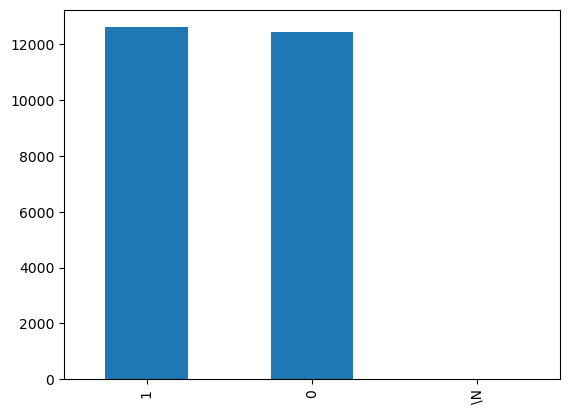

In [79]:
data['video_category'].value_counts().plot.bar()

In [80]:
# drop `\N` records in video_category
data = data[data['video_category'] != "\\N"]
data['video_category'] = data['video_category'].astype('int')

### Normalization or Scaling

<Axes: >

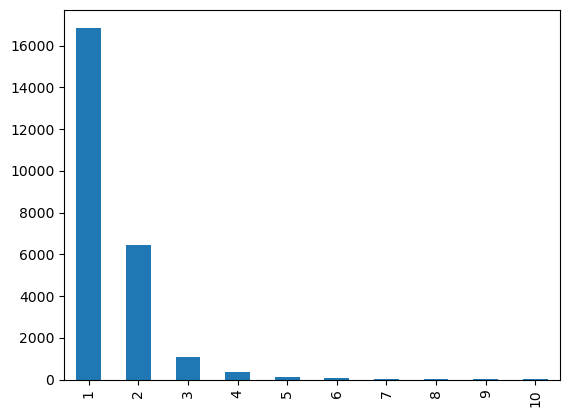

In [81]:
data['watching_times'].value_counts().head(10).plot.bar()

In [82]:
# # Normalize the "watching_times" column
# def normalize_column(column):
#     min_val = column.min()
#     max_val = column.max()
#     normalized_column = (column - min_val) / (max_val - min_val)
#     return np.round(normalized_column, 2)

# data['watching_times'] = normalize_column(data['watching_times'])

---

## Data Analysis (ERD)

#### Value Counts
display top 10 value counts for each feature (column)

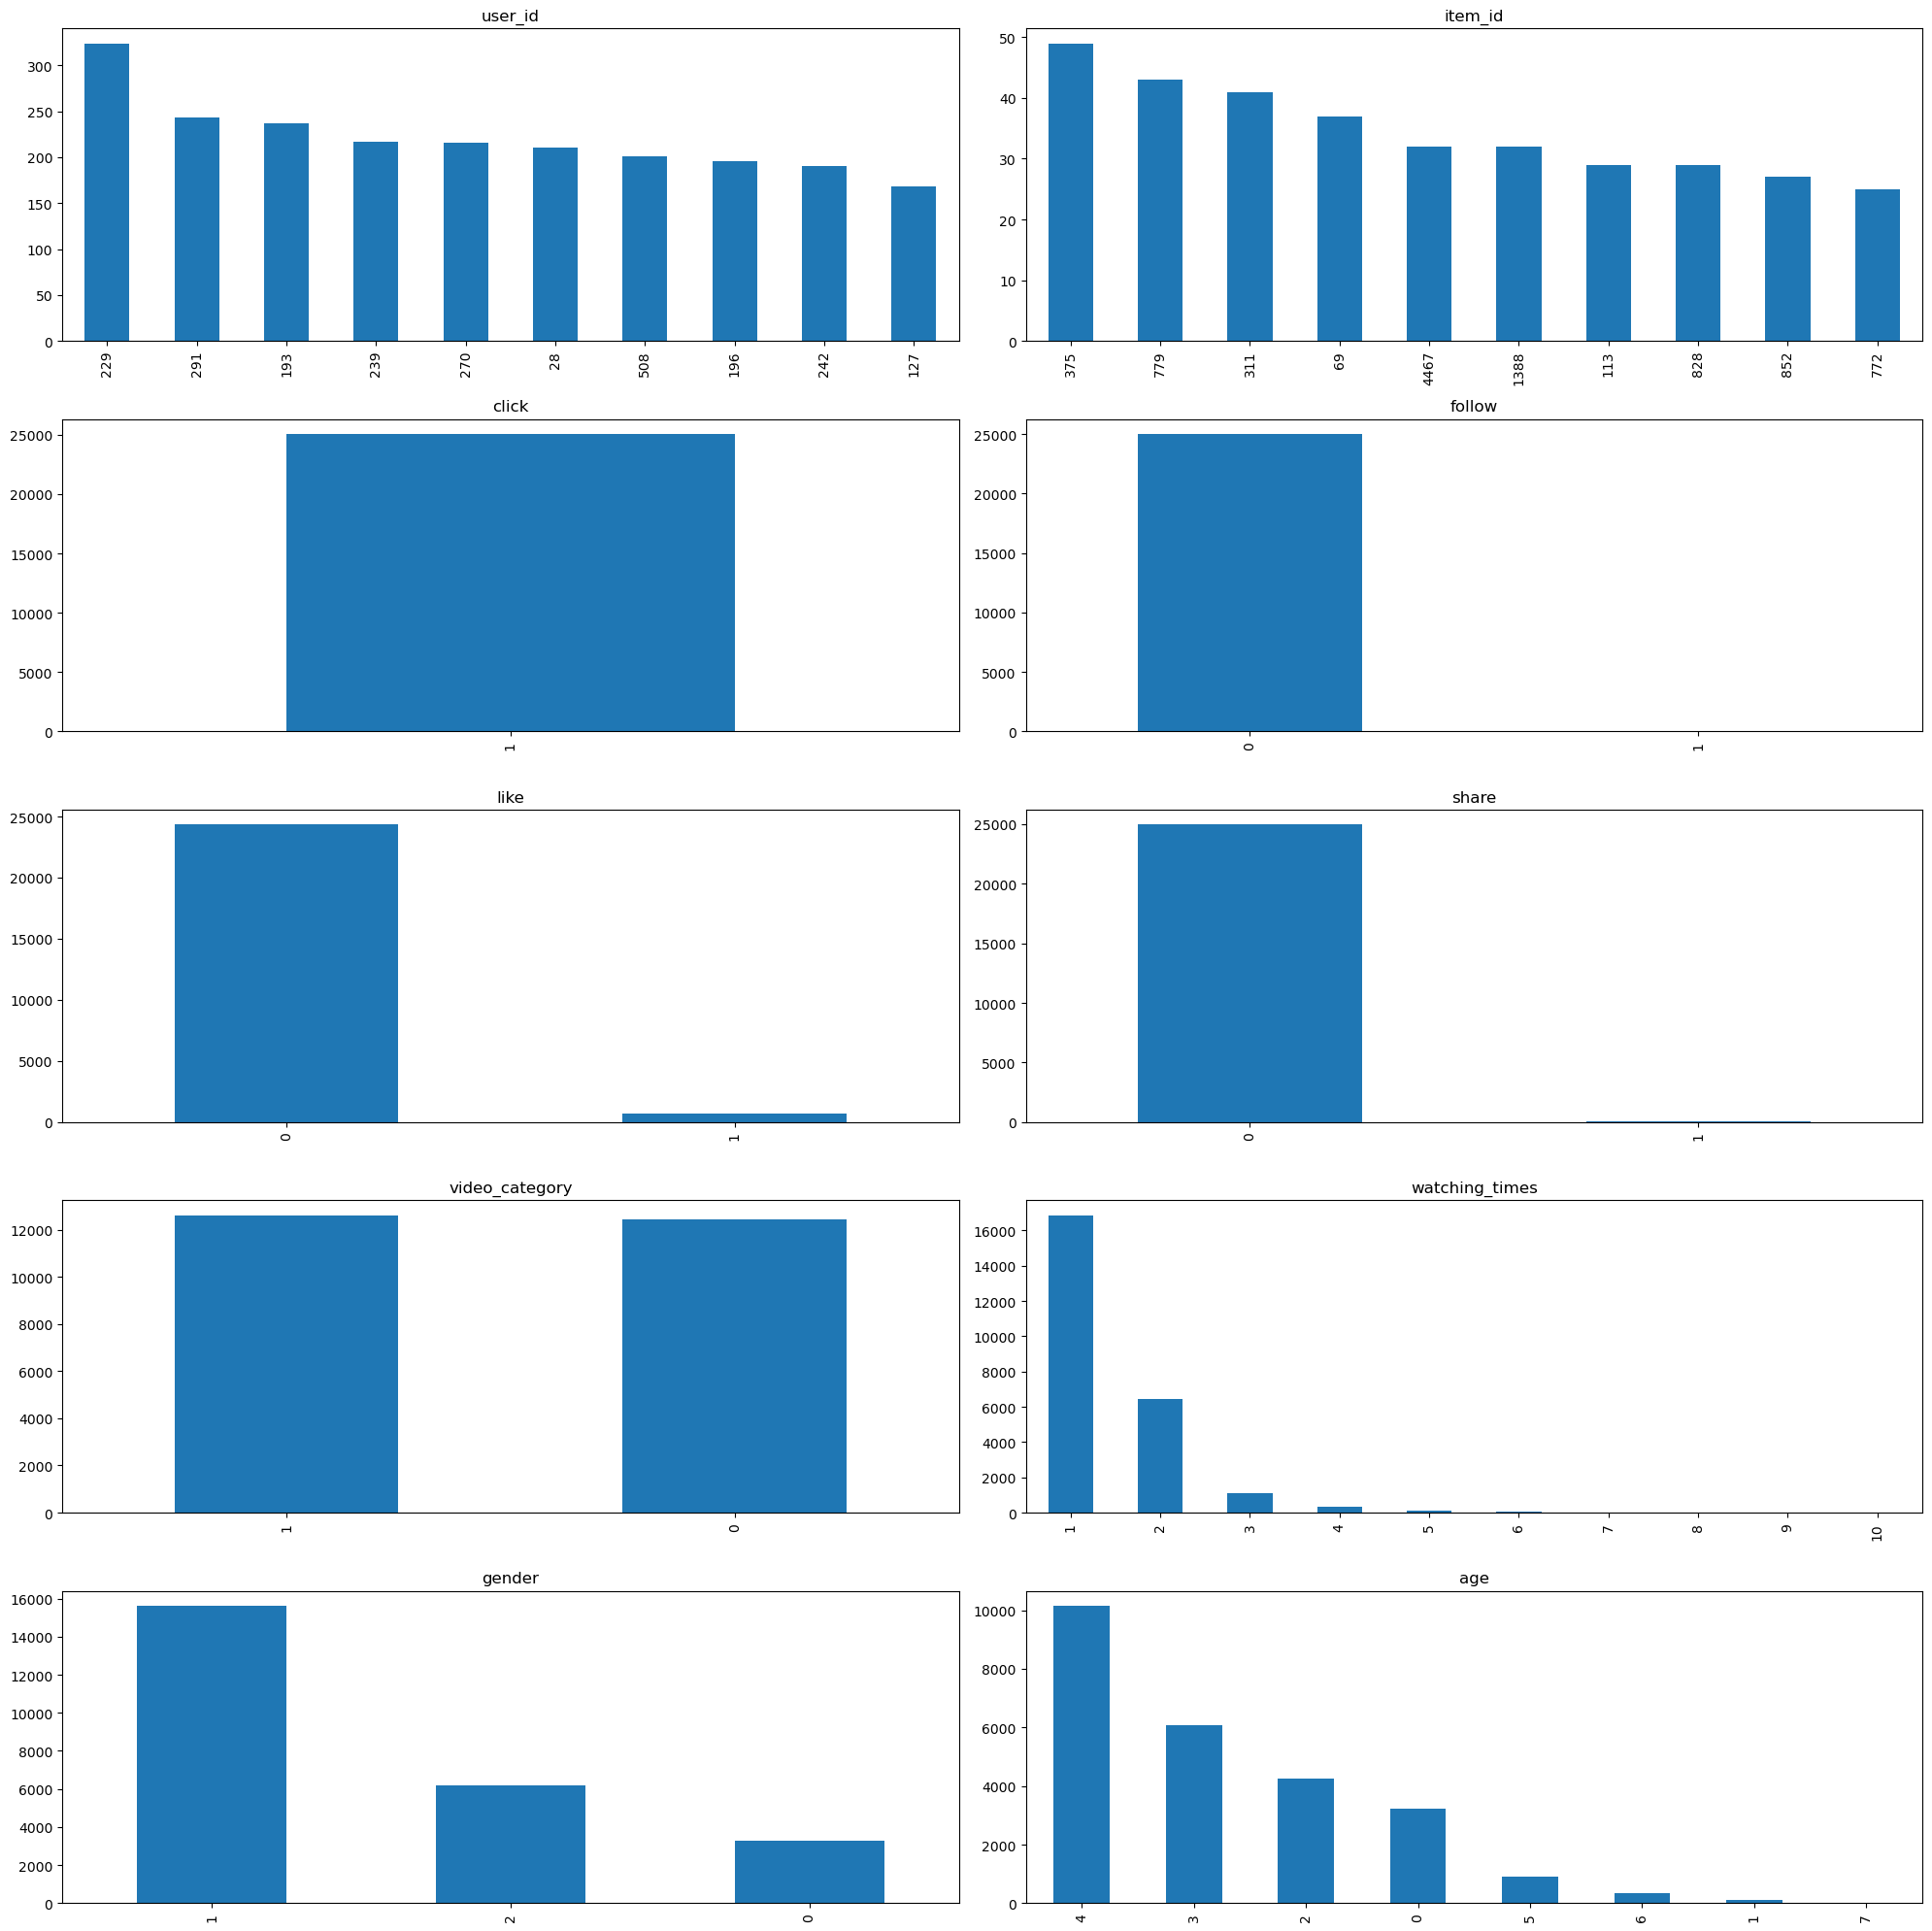

In [83]:
display_value_counts_bar(data, 2)

### Video Categories

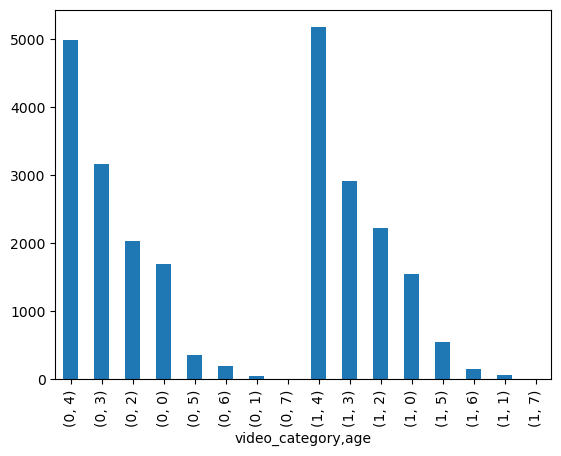

In [84]:
display_value_counts_between(data, 'video_category', 'age')

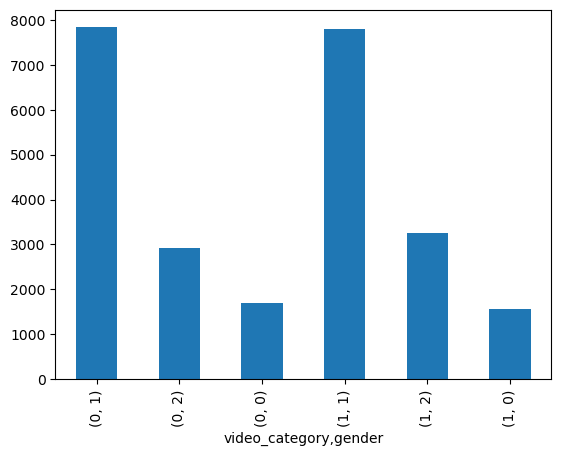

In [85]:
display_value_counts_between(data, 'video_category', 'gender')

### Gender Distribution

In [86]:
data['gender'].corr(data['age'])

0.629984835928496

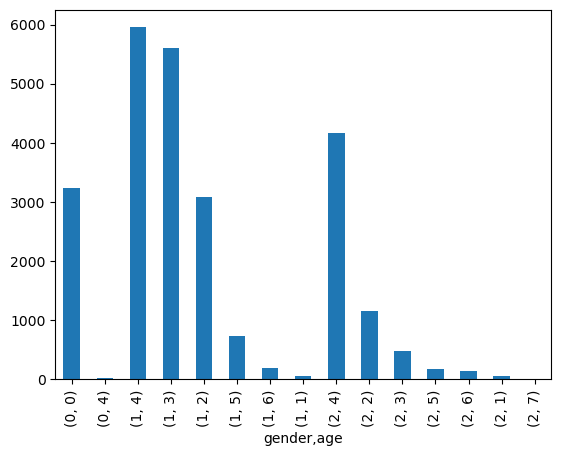

In [87]:
display_value_counts_between(data, 'gender', 'age')

### Items Analysis

<Axes: >

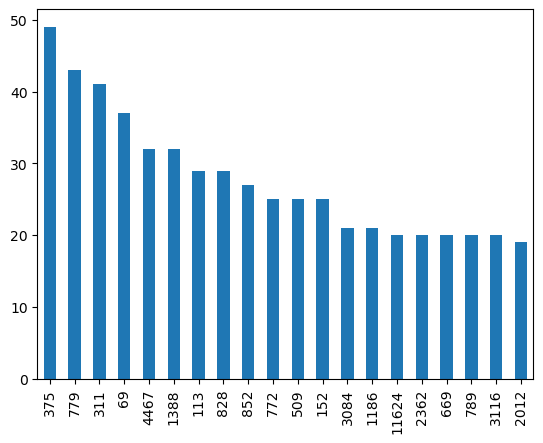

In [88]:
data['item_id'].value_counts().sort_values(ascending=False).head(20).plot.bar()

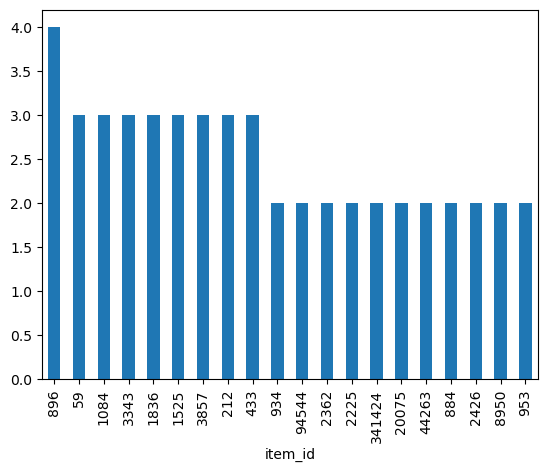

In [89]:
data['interactions'] = data['follow'] + data['share'] + data['like']
display_sum_between(data, 'item_id', 'interactions')
data.drop(columns=['interactions'], axis=1, inplace=True)

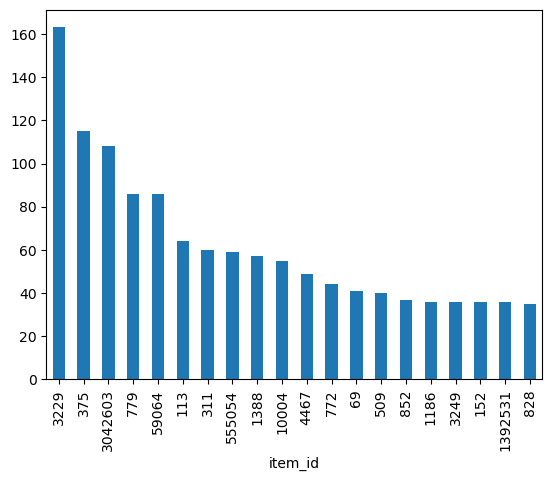

In [90]:
display_sum_between(data, 'item_id', 'watching_times')

<Axes: >

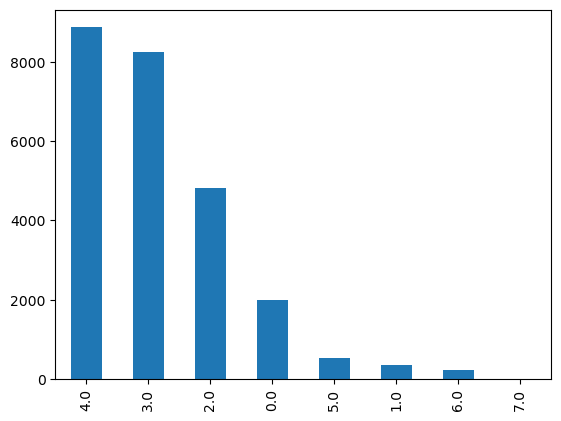

In [91]:
np.round(data.groupby('item_id')['age'].transform('mean'), 0).value_counts().plot.bar()

In [92]:
num_items = data['item_id'].nunique()
num_items

17068

### Sessions Analysis

In [93]:
num_users = data['user_id'].nunique()
num_users

550

In [94]:
data['user_id'].value_counts().sort_values(ascending=False).describe()

count    550.000000
mean      45.580000
std       39.783796
min        3.000000
25%       19.000000
50%       34.000000
75%       55.000000
max      324.000000
Name: user_id, dtype: float64

Once session sequences are from `1` to `563` but `50%` are of length `34` or less and `75%` are `59` or less, we can use a mean point `45` as max sequance length to reduce the number of padding in the data and we can also make the min sequance length as `10` instead of `1` where any number less than `10` can't create a meaningful sequance.

---

## Collaborative Filtering

Ways to determine whether user-based or item-based collaborative filtering is more suitable:

- User-based filtering is better when you have a large number of users with consistent preferences and behaviors, and when users have interacted with a significant portion of the available items.
- Item-based filtering is better when you have a large number of items with consistent characteristics and interactions, and when users have interacted with only a small fraction of the available items.

In [95]:
data['user_id'].nunique()

550

In [96]:
data['item_id'].nunique()

17068

They are near to each others.

- If your data is highly sparse (few interactions per user), item-based filtering is more suitable. If your data is less sparse (many interactions per user), user-based filtering may be more suitable.

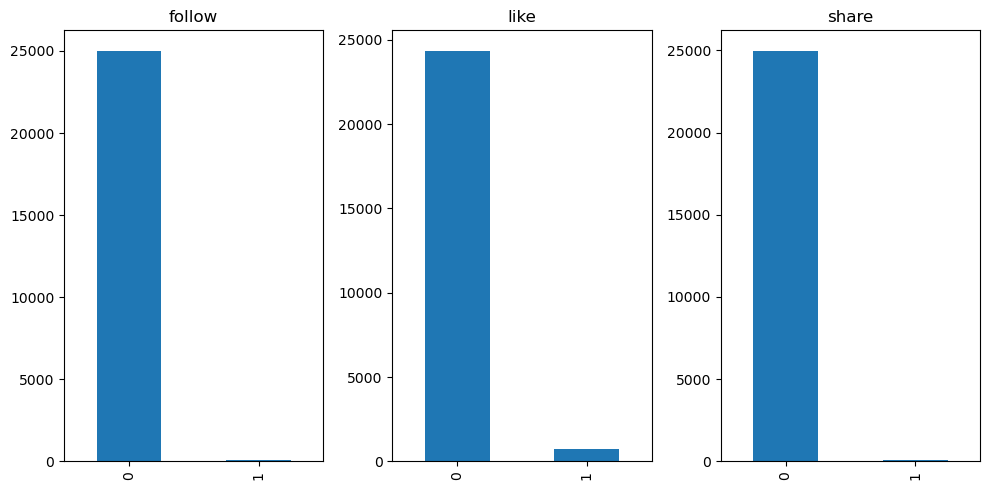

In [97]:
display_value_counts_bar(data[['follow', 'like', 'share']], 3)

Data is highly sparse, So we can say that Item-Based filtering is more suitable.

---

## Save Point

In [98]:
# Load the dataset
df = data.copy()

---

## Features Engineering

<Axes: >

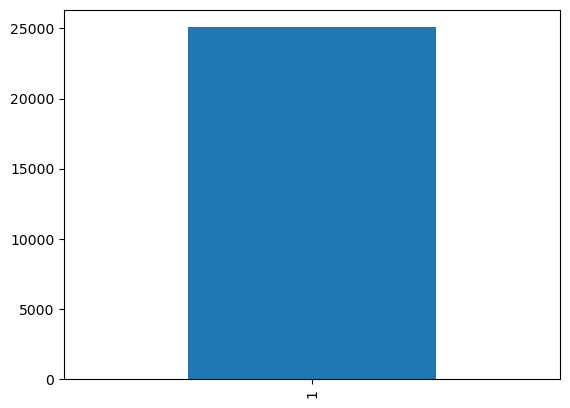

In [99]:
# The column `click` contains only the value `1` so it is better to be dropped.
df['click'].value_counts().plot.bar()

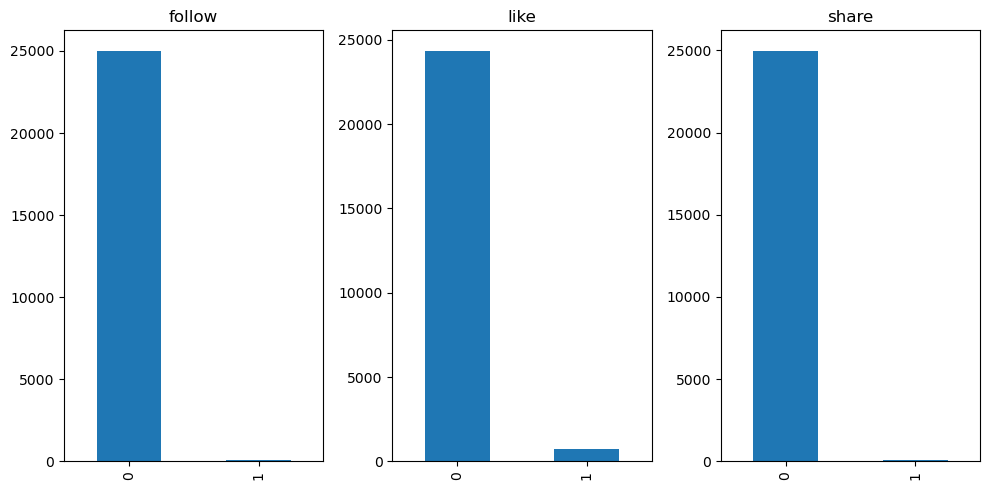

In [100]:
# follow, like and share are highly sparse so it is better to drop them.
display_value_counts_bar(df[['follow', 'like', 'share']], 3)

In [101]:
df.drop(columns=['click', 'follow', 'like', 'share'], axis=1, inplace=True)

---

## Session Representation
- Session Initialization
- Session Length Filtering
- Session Sorting - already sorted
- Session Padding

### Map Items ids

In [102]:
itemIdMapping = {k:i+1 for i, k in enumerate(sorted(list(df['item_id'].unique())))}

In [103]:
df["item_id_mapped"] = df['item_id'].map(itemIdMapping)

In [104]:
df.head()

,user_id,item_id,video_category,watching_times,gender,age,item_id_mapped
0,1,1,1,1,1,4,1
1,1,2,1,1,1,4,2
2,1,3,0,1,1,4,3
3,1,80936,1,1,1,4,9023
4,1,781,1,1,1,4,452


### Session Initialization

In [105]:
sessions = df.groupby("user_id")[['item_id_mapped']].agg(list)

In [106]:
sessions.head()

,item_id_mapped
user_id,
1,"[1, 2, 3, 9023, 452, 9812, 739, 6213, 589, 137..."
2,"[5, 6, 7, 8, 9, 5588, 8694, 2706, 3944, 6777, ..."
3,"[12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 2..."
4,"[34, 41, 45, 9956, 3304, 4363, 2372, 7885, 844..."
5,"[48, 49, 9179, 5686, 8808, 9186, 8885, 624, 44..."


### Session Length Filtering

In [107]:
min_sequance_length = 20
max_sequance_length = 45

In [108]:
# filter min length
sessions = sessions[sessions['item_id_mapped'].apply(lambda x: len(x) > min_sequance_length)]

In [109]:
# apply max length
sessions['item_id_mapped'] = sessions['item_id_mapped'].apply(lambda x: x[:max_sequance_length])

In [110]:
sessions['item_id_mapped'].values

array([list([1, 2, 3, 9023, 452, 9812, 739, 6213, 589, 1379, 716, 715, 11451, 7900, 5236, 207, 1882, 2136, 9768, 13509, 13511, 15571, 13766, 10086, 14077, 14591, 13551, 14415, 13627, 14668, 13097, 14629, 14197, 10230, 11283, 15649, 15157, 13793, 13792, 13507, 13851, 8772, 13823, 13708, 599]),
       list([12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 5158, 11421, 11631, 1454, 5886, 5683, 4069, 1631, 8842, 6400, 8096, 7786, 1130, 8276, 4633, 3512, 10516, 612, 3449, 5583, 2687, 6712]),
       list([34, 41, 45, 9956, 3304, 4363, 2372, 7885, 844, 942, 5195, 3369, 2051, 13901, 14150, 16377, 14915, 14940, 13552, 16436, 13875, 14860, 13724, 14834, 15060, 13816, 15495]),
       list([48, 49, 9179, 5686, 8808, 9186, 8885, 624, 4447, 880, 10300, 3505, 16061, 8780, 14083, 14650, 13822, 15207, 14340, 14565, 14689, 15400, 14820, 14644, 550, 15667, 13562, 14101, 6456, 3501, 14997, 16637, 15353, 8618, 13803, 14587, 16608, 14275, 15136, 5421, 13773, 14471, 4586, 15290, 13806]),
       li

### Session Padding
add padding to the beginning of each sequance

In [111]:
sessions['item_id_mapped'] = sessions['item_id_mapped'].apply(lambda x: [0]*(max_sequance_length-len(x)) + x)

In [112]:
sessions.head()

,item_id_mapped
user_id,
1,"[1, 2, 3, 9023, 452, 9812, 739, 6213, 589, 137..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 14, 15, 16, 1..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[48, 49, 9179, 5686, 8808, 9186, 8885, 624, 44..."
6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52,..."


---

## Train-Test-Validation Split

In [113]:
train_ratio = 0.9
test_ratio = 0.1

train_size = int(train_ratio * len(sessions))
train_data = sessions[:train_size]
test_data = sessions[train_size:]

In [114]:
print(f"Preprocessed Training Data: {len(train_data)}")
print(f"Preprocessed Testing Data: {len(test_data)}")

Preprocessed Training Data: 347
Preprocessed Testing Data: 39


---

## Model Selection

Steps for Session-Based Recommendation:

- Research and Understanding: Familiarize yourself with the characteristics, strengths, and limitations of each model considered for session-based recommendation, namely BERT4Rec, GRU4Rec, SASRec, and NextItNet. Gain insights into their architectures, training approaches, and performance on similar tasks.

- Evaluation Metrics: Determine the evaluation metrics that align with your project goals, such as precision, recall, Mean Average Precision (MAP), or Normalized Discounted Cumulative Gain (NDCG). Ensure that the selected models can be evaluated using these metrics.

- Implementation Suitability: Assess the feasibility and compatibility of each model with the Ternec dataset, session-based recommendation task, and available computational resources. Consider factors such as model complexity, scalability, and ease of implementation.

- Model Performance Comparison: Implement and train each model separately using the Ternec dataset. Evaluate their performance on the chosen evaluation metrics using appropriate validation or test sets. Compare their results to identify the model(s) that demonstrate superior performance.

- Consideration of Specific Requirements: Consider any specific requirements or constraints of your session-based recommendation project. For example, if interpretability is crucial, assess which model provides more explainable recommendations. Take into account factors like model complexity, training time, or memory requirements.

- Robustness and Generalization: Analyze the robustness and generalization capabilities of each model by assessing their performance across different subsets or splits of the Ternec dataset. Consider their ability to handle various session lengths, data sparsity, or different user behavior patterns.

- Expert Advice: Consult with experts or researchers in the field of session-based recommendation or deep learning to gather additional insights and recommendations on model selection. Consider their expertise and experiences to inform your decision-making process.

- Final Model Selection: Based on the performance comparison, compatibility, requirements, and expert advice, select the model(s) that best meet your project goals, dataset characteristics, and implementation constraints. Ensure that the selected models align with the objectives and resources available for your session-based recommendation project.

### BERT4Rec by Manar El-Ghobashy

In [115]:
# todo

#### Model Training

In [116]:
# todo

#### Model Evaluation

In [117]:
# todo

### Performance Analysis

In [118]:
# todo

### GRU4Rec by Yara El-Zahy

#### Model Training

In [119]:
# todo

#### Model Evaluation

In [120]:
# todo

### Performance Analysis

In [121]:
# todo

### SASRec by Yara Mohammed

#### Model Training

In [122]:
# todo

#### Model Evaluation

In [123]:
# todo

### Performance Analysis

In [124]:
# todo

### NextItNet by Adham Mokhtar

In [125]:
nextitnet_train_data = np.array(train_data['item_id_mapped'].tolist())
nextitnet_test_data = np.array(test_data['item_id_mapped'].tolist())

In [126]:
def extract_labels(data, max_sequance_length):
    X = []
    Y = []
    for seq in data:
        x = seq[:-1]
        y = seq[1:]

        x = x[:max_sequance_length]
        y = y[:max_sequance_length]
        
        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y)

In [127]:
nextitnet_x_train, nextitnet_y_train = extract_labels(nextitnet_train_data, max_sequance_length)
nextitnet_x_test, nextitnet_y_test = extract_labels(nextitnet_test_data, max_sequance_length)

In [128]:
# Define hyperparameters
input_dim = num_items
embedding_dim = 16 # number of features/columns - less is faster
num_blocks = 2
dilations = [1, 2, 4]
kernel_size = 3
output_dim = num_items
batch_size = 32
epochs = 10

### Create Model

In [129]:
def nextitnet_model(input_dim, embedding_dim, num_blocks, dilations, kernel_size, output_dim):
    input_seq = tf.keras.layers.Input(shape=(None,))
    embedded_seq = tf.keras.layers.Embedding(input_dim, embedding_dim)(input_seq)
    
    conv_layers = []
    for dilation in dilations:
        conv = tf.keras.layers.Conv1D(filters=embedding_dim, kernel_size=kernel_size, dilation_rate=dilation, activation='relu', padding='causal')(embedded_seq)
        conv_layers.append(conv)
    
    # Add the residual blocks
    for _ in range(num_blocks):
        residual = conv_layers[-1]
        for dilation in dilations:
            conv = tf.keras.layers.Conv1D(filters=embedding_dim, kernel_size=kernel_size, dilation_rate=dilation, activation='relu', padding='causal')(residual)
            conv_layers.append(conv)
            residual = tf.keras.layers.Add()([residual, conv])
    
    concatenated = tf.keras.layers.Concatenate()(conv_layers)
    output = tf.keras.layers.Dense(output_dim, activation='softmax')(concatenated)
    
    return tf.keras.Model(inputs=input_seq, outputs=output)

In [130]:
# Create and compile the model
model = nextitnet_model(input_dim, embedding_dim, num_blocks, dilations, kernel_size, output_dim)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model Training

In [131]:
# Train the model
model.fit(nextitnet_x_train, nextitnet_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10


10/10 [==============================] - 2s 142ms/step - loss: 9.7415 - accuracy: 0.0745 - val_loss: 9.7306 - val_accuracy: 0.1708
Epoch 2/10
10/10 [==============================] - 1s 120ms/step - loss: 9.6804 - accuracy: 0.1367 - val_loss: 9.6564 - val_accuracy: 0.1695
Epoch 3/10
10/10 [==============================] - 1s 115ms/step - loss: 9.3575 - accuracy: 0.1315 - val_loss: 9.5471 - val_accuracy: 0.1610
Epoch 4/10
10/10 [==============================] - 1s 110ms/step - loss: 8.7732 - accuracy: 0.1352 - val_loss: 10.1092 - val_accuracy: 0.1701
Epoch 5/10
10/10 [==============================] - 1s 112ms/step - loss: 8.3604 - accuracy: 0.1352 - val_loss: 9.8444 - val_accuracy: 0.1701
Epoch 6/10
10/10 [==============================] - 1s 115ms/step - loss: 8.1079 - accuracy: 0.1352 - val_loss: 9.7888 - val_accuracy: 0.1701
Epoch 7/10
10/10 [==============================] - 1s 114ms/step - loss: 7.8689 - accuracy: 0.1352 - val_loss: 9.8691 - val_accuracy: 0.1701
Epoch 8/10
10/10

#### Model Evaluation

In [132]:
# Evaluate the model
loss, accuracy = model.evaluate(nextitnet_x_test, nextitnet_y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

2/2 [==============================] - 0s 13ms/step - loss: 11.1968 - accuracy: 0.1259
Test Loss: 11.196765899658203
Test Accuracy: 0.1258741319179535


### Performance Analysis

In [133]:
# todo

## Conclusion

In [134]:
# todo